# ESPEI

### Extensible Self-optimizating Phase Equilibria Infrastructure

Documentation for internal and external APIs can be found at https://espei.org

Solutions to this notebook can be found at https://github.com/materialsgenomefoundation/2021-workshop-material

## Starting an assessment

To perform thermodynamic assessments in ESPEI you need:

1. A JSON-formatted file that describes the phases to be assessed
2. A directory containing one or more JSON-formatted files (following the schema at https://espei.org/en/latest/input_data.html#making-espei-datasets) of non-equilibrium thermochemical data, equilibrium thermochemical data, and phase boundary data
3. A YAML file that declares what fitting steps should be run and allows for tuning hyperparameters

The names these files are given do not matter. Some are named by convention (e.g. `phases.json` to hold the phase descriptions) and others can be used more descriptively (e.g. `CR-NI-HM_FORM-FCC_A1-watson1995enthapies.json` for binary enthalpy of formation data from a paper referenced as `watson1995enthapies`).

### Phase descriptions

See detailed documentation at https://espei.org/en/latest/input_data.html#phase-descriptions

The `phases.json` file contains the species and phases in the assessment.

Each phase requires a definition for:

* `sublattice_model`: how many sublattices will be used to model this phase and which chemical species may enter
* `sublattice_site_ratios`: the stoichiometric ratios for each sublattice
* (optional) `aliases`: a list of alternative names that the phase can have

Using Cr-Ni as a simple example, we can model three solution phases using one sublattice each.

```json
{
    "components": ["CR", "NI"],
    "phases": {
        "LIQUID" : {
            "sublattice_model": [["CR", "NI"]],
            "sublattice_site_ratios": [1]
        },
        "BCC_A2": {
            "sublattice_model": [["CR", "NI"]],
			"sublattice_site_ratios": [1]
	    },
        "FCC_A1": {
            "sublattice_model": [["CR", "NI"]],
            "sublattice_site_ratios": [1]
        }
    }
}
```

### JSON files

Many different types and representations of thermodynamic data exist. ESPEI currently targets 3 classes of data and is designed to be exensible to support any type of data that could be forward-calculated using pycalphad.

* **Non-equilibrium thermochemical data** (where the thermodynamic quantity and internal degrees of freedom for a stable, metastable, or unstable phase is known)
* **Equilibrium thermochemical data** (where the thermodynamic quantity of a stable or metastable phase is known)
* **Phase boundary data** (the conditions where a new phase becomes stable or an existing phase becomes metastable)

Parameter generation (this notebook) only supports non-equilibrium thermochemical data. Markov Chain Monte Carlo fitting and uncertainty quantification can handle any type of data. In this workshop, we will only use non-equilibrium thermochemical data and phase boundary data. These data are described in detail in [ESPEI's datasets documentation](https://espei.org/en/latest/input_data.html).

#### Non-equilibrium thermochemical data

```json
{
  "components": ["CR", "NI"],
  "phases": ["FCC_A1"],
  "solver": {
    "mode": "manual",
    "sublattice_site_ratios": [1],
    "sublattice_configurations": [ [["CR", "NI"]], [["CR", "NI"]], [["CR", "NI"]], [["CR", "NI"]]],
    "sublattice_occupancies":    [ [[0.10, 0.90]], [[0.10, 0.90]], [[0.40, 0.60]], [[0.40, 0.60]]]
  },
  "conditions": {
    "P": 101325,
    "T": 1583
  },
  "output": "HM_FORM",
    "values":   [[[-1100, -1510, 2880, 3280]]],
  "reference": "watson1995enthapies",
  "comment": "From Table 5. Converted from kJ to J. Two phase data neglected."
}

```

#### Phase boundary data

```json
{
    "components": ["CR", "NI"],
    "phases": ["BCC_A2", "FCC_A1"],
    "broadcast_conditions": false,
    "conditions": {
        "T": [1073, 1173, 1273, 1373, 1548],
        "P": [101325.0]
    },
    "output": "ZPF",
    "values": [
        [["FCC", ["CR"], [0.3866]], ["BCC", ["NI"], [null]]],
        [["FCC", ["CR"], [0.3975]], ["BCC", ["NI"], [null]]],
        [["FCC", ["CR"], [0.4480]], ["BCC", ["NI"], [null]]],
        [["FCC", ["CR"], [0.4643]], ["BCC", ["NI"], [null]]],
        [["FCC", ["CR"], [0.4984]], ["BCC", ["NI"], [null]]]
    ],
    "reference": "bechtoldt1961redetermination",
    "comment": "Digitized from figure 5, points in figure 4 were too far apart to identify a boundary properly."
}
```


### Input YAML files 

```yaml
system:
  phase_models: phases.json
  datasets: input-data

output:
  verbosity: 1
  output_db: dft.tdb

generate_parameters:
  excess_model: linear
  ref_state: SGTE91
```

## Parameter generation

In [1]:
import yaml
from espei import run_espei
from pycalphad import Database, binplot, equilibrium, variables as v

In [2]:
with open('generate_params_settings.yaml') as fp:
    generate_params_settings = yaml.safe_load(fp)

In [3]:
dbf = run_espei(generate_params_settings)

INFO:espei.espei_script - espei version       0.8.4
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.paramselect - Generating parameters.
INFO:espei.paramselect - FITTING: BCC_A2
INFO:espei.paramselect - FITTING: FCC_A1
INFO:espei.paramselect - FITTING: LIQUID
INFO:espei.paramselect - Finished generating parameters.


<AxesSubplot:title={'center':'CR-NI'}, xlabel='X(NI)', ylabel='Temperature (K)'>

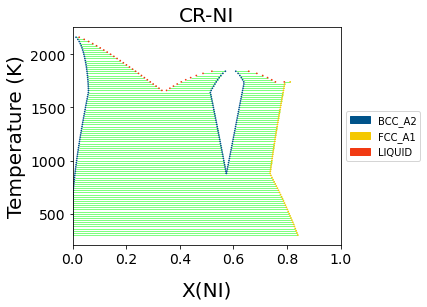

In [4]:
comps = ['CR', 'NI']
phases = ['FCC_A1', 'BCC_A2', 'LIQUID']
conds = {v.N: 1.0, v.P: 101325, v.T: (300, 2300, 20), v.X('NI'): (0, 1, 0.02)}
binplot(dbf, comps, phases, conds)

Now that we have an initial fit to only the derivatives of the Gibbs energy functions, we can judge our initial parameterization against the phase diagram data.

All data is stored in JSON files, so we can load that into an in-memory database of `datasets`.

In [5]:
from espei.plot import dataplot
from espei.datasets import recursive_glob, load_datasets

# load our JSON datasets into an in-memory database
datasets = load_datasets(recursive_glob('input-data', '*.json'))

Then plot the binary phase diagram with these new datasets on the same axes

<AxesSubplot:title={'center':'CR-NI'}, xlabel='X(NI)', ylabel='Temperature (K)'>

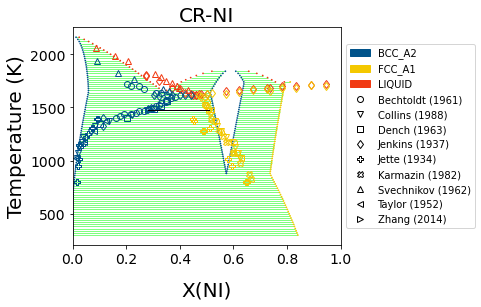

In [6]:
# plot the binary phase diagram, saving the output matplotlib axes as a variable
ax = binplot(dbf, comps, phases, conds)

# plot the phase boundary data as marked points
dataplot(comps, phases, conds, datasets, ax=ax)

## Understanding parameter generation

We can use pycalphad to plot the Gibbs energy surface to get an idea about what is causing BCC to become stable: 

Text(0.5, 1.0, 'Cr-Ni Energy Surface')

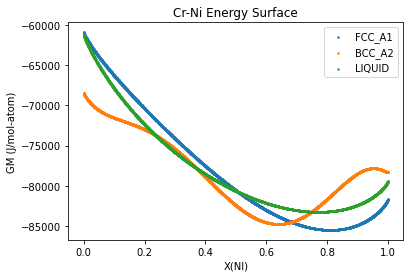

In [7]:
from pycalphad import calculate
import matplotlib.pyplot as plt
calc_res = calculate(dbf, comps, phases, T=1500, N=1, P=101325)
for phase_name in phases:
    mask = calc_res.Phase == phase_name
    plt.scatter(calc_res.X.sel(component='NI'), calc_res.GM.where(mask), s=2, label=phase_name)
plt.legend()
plt.xlabel("X(NI)")
plt.ylabel("GM (J/mol-atom)")
plt.title("Cr-Ni Energy Surface")

The BCC phase seems to have a strange shape. Investigating the parameters and data that were fit may reveal the underlying issue. 

ESPEI provides `plot_interaction` to visualize how ESPEI fit our thermochemical data to the interaction parameters.

In [8]:
from espei.plot import plot_interaction

<AxesSubplot:xlabel='CR to NI', ylabel='Enthalpy of Mixing (J/mol-atom)'>

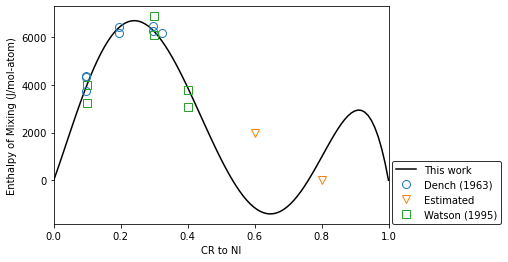

In [9]:
plot_interaction(dbf, comps, 'BCC_A2', (('CR', 'NI'),), 'HM_MIX', datasets=datasets, symmetry=None)

<AxesSubplot:xlabel='CR to NI', ylabel='Enthalpy of Mixing (J/mol-atom)'>

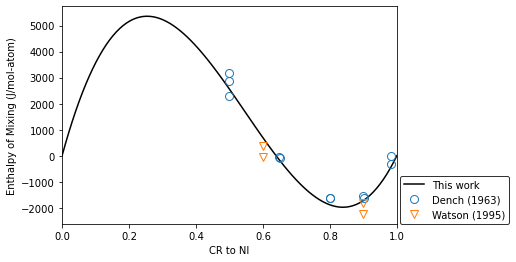

In [10]:
plot_interaction(dbf, comps, 'FCC_A1', (('CR', 'NI'),), 'HM_MIX', datasets=datasets, symmetry=None)

<AxesSubplot:xlabel='CR to NI', ylabel='Enthalpy of Mixing (J/mol-atom)'>

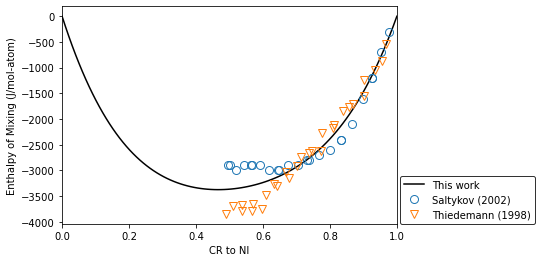

In [11]:
plot_interaction(dbf, comps, 'LIQUID', (('CR', 'NI'),), 'HM_MIX', datasets=datasets, symmetry=None)

To be more quantitative, the parameters in the pycalphad Database can be searched for the excess parameters that were fit.

The mathematical expression for each excess parameter is found in the `parameter` key, i.e. for the first parameter:

$$ {}^{0} L^{\mathrm{BCC\_A2}} = \mathrm{VV0006} + \mathrm{VV0005} T $$

where $ \mathrm{VV0005} $ and $ \mathrm{VV0006} $ are symbols that are generated by ESPEI during the fitting.

In [12]:
import tinydb
dbf._parameters.search(
    (tinydb.where('phase_name') == 'BCC_A2') &   # LIQUID phase parameters
    (tinydb.where('parameter_type') == 'L')      # Parameters of type L (i.e. excess parameters)
)

[{'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 0,
  'parameter': T*VV0005 + VV0006,
  'diffusing_species': None,
  'reference': None},
 {'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 1,
  'parameter': T*VV0003 + VV0004,
  'diffusing_species': None,
  'reference': None},
 {'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 2,
  'parameter': T*VV0001 + VV0002,
  'diffusing_species': None,
  'reference': None},
 {'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 3,
  'parameter': VV0000,
  'diffusing_species': None,
  'reference': None}]

The `dbf.symbols` dictionary maps the name of symbols in the database to their values. We can look up the value of $ \mathrm{VV0016}$

In [13]:
print(f"L0-BCC_A2 = {dbf.symbols['VV0006']} + {dbf.symbols['VV0005']}*T")

L0-BCC_A2 = 3527.86 + -3.45952*T


## Tuning parameter selection

Looking again at the parameterization for BCC_A2, we can see that the optimal tradeoff between the goodness of fit and number of parameter according to the corrected Akiake information criterion was to choose 4 excess parameters ($ {}^{0} L $, $ {}^{1} L $, $ {}^{2} L $, and $ {}^{3} L $).

Judging by eye, we may have some intuition that the AICc was wrong. 

<AxesSubplot:xlabel='CR to NI', ylabel='Enthalpy of Mixing (J/mol-atom)'>

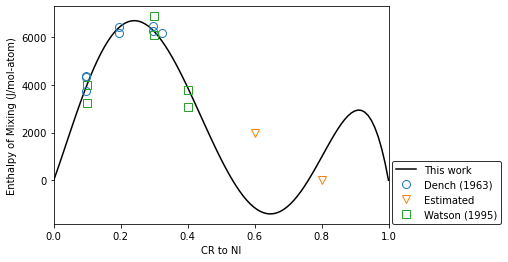

In [14]:
plot_interaction(dbf, comps, 'BCC_A2', (('CR', 'NI'),), 'HM_MIX', datasets=datasets, symmetry=None)

In ESPEI, there are a variety of ways to tune and use modeling expertise to influence the automated parameterization. One of them is by using the `aicc_penalty_factor` option ([documented in more detail here](https://espei.org/en/latest/writing_input.html#aicc-penalty-factor)) to increase the penalty for introducing more fitting parameters.

The default is `aicc_penalty_factor = 1.0` for every phase and data type. `aicc_penalty_factor > 1` will increase the penalty for increasing the number of parameters. For the liquid phase, we can increase the penalty factor as follows (`generate_params_settings_aicc_penalty.yaml`):

```yaml
system:
  phase_models: Cr-Ni_phases.json
  datasets: input-data
  tags:
    dft:
      excluded_model_contributions: ['idmix', 'mag']
      weight: 0.1
    nomag:
      excluded_model_contributions: ['mag']
    estimated-entropy:
      excluded_model_contributions: ['idmix', 'mag']
      weight: 0.1
generate_parameters:
  excess_model: linear
  ref_state: SGTE91
  aicc_penalty_factor:
    BCC_A2:
      HM: 2.0
      SM: 2.0
    LIQUID:
      HM: 10
      SM: 10
output:
  verbosity: 1
  output_db: generated-aicc.tdb
```

Then we can fit a new database:

In [15]:
with open('generate_params_settings-aicc_penalty.yaml') as fp:
    generate_params_settings = yaml.safe_load(fp)

In [16]:
dbf_aicc_penalty = run_espei(generate_params_settings)

INFO:espei.espei_script - espei version       0.8.4
INFO:espei.espei_script - If you use ESPEI for work presented in a publication, we ask that you cite the following paper:
    B. Bocklund, R. Otis, A. Egorov, A. Obaied, I. Roslyakova, Z.-K. Liu, ESPEI for efficient thermodynamic database development, modification, and uncertainty quantification: application to Cu-Mg, MRS Commun. (2019) 1-10. doi:10.1557/mrc.2019.59.
INFO:espei.paramselect - Generating parameters.
INFO:espei.paramselect - FITTING: BCC_A2
INFO:espei.paramselect - FITTING: FCC_A1
INFO:espei.paramselect - FITTING: LIQUID
INFO:espei.paramselect - Finished generating parameters.


Now we can verify the new parameterization for the BCC_A2 phase:

In [17]:
dbf_aicc_penalty._parameters.search(
    (tinydb.where('phase_name') == 'BCC_A2') &   # LIQUID phase parameters
    (tinydb.where('parameter_type') == 'L')      # Parameters of type L (i.e. excess parameters)
)

[{'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 0,
  'parameter': T*VV0002 + VV0003,
  'diffusing_species': None,
  'reference': None},
 {'phase_name': 'BCC_A2',
  'constituent_array': ((Species('CR', 'CR1'), Species('NI', 'NI1')),),
  'parameter_type': 'L',
  'parameter_order': 1,
  'parameter': T*VV0000 + VV0001,
  'diffusing_species': None,
  'reference': None}]

<AxesSubplot:xlabel='CR to NI', ylabel='Enthalpy of Mixing (J/mol-atom)'>

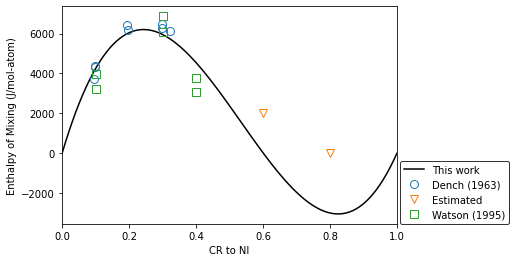

In [18]:
plot_interaction(dbf_aicc_penalty, comps, 'BCC_A2', (('CR', 'NI'),), 'HM_MIX', datasets=datasets, symmetry=None)

Text(0.5, 1.0, 'Cr-Ni Energy Surface')

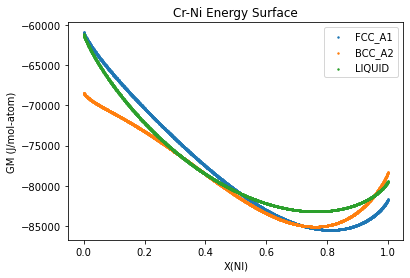

In [19]:
calc_res = calculate(dbf_aicc_penalty, comps, phases, T=1500, N=1, P=101325)
for phase_name in phases:
    mask = calc_res.Phase == phase_name
    plt.scatter(calc_res.X.sel(component='NI'), calc_res.GM.where(mask), s=2, label=phase_name)
plt.legend()
plt.xlabel("X(NI)")
plt.ylabel("GM (J/mol-atom)")
plt.title("Cr-Ni Energy Surface")

<AxesSubplot:title={'center':'CR-NI'}, xlabel='X(NI)', ylabel='Temperature (K)'>

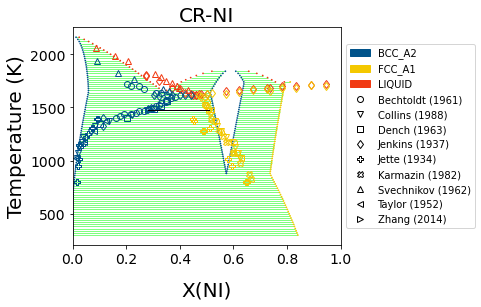

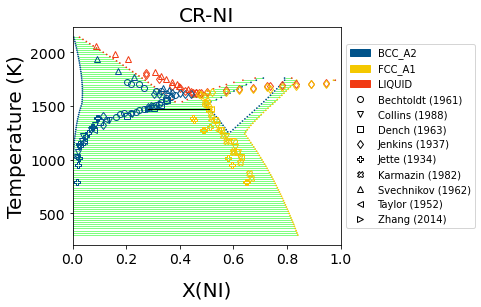

In [20]:
# Original database with four BCC_A2 excess parameters
ax = binplot(dbf, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)

# New database with two excess parameters
ax = binplot(dbf_aicc_penalty, comps, phases, conds)
dataplot(comps, phases, conds, datasets, ax=ax)